# Kaggle Tabular dataset competitions

#Table of contents
# 1. Importing libraries
# 2. Loading data
# 3. Data exploration
# 4. Data cleaning
# 5. Feature engineering 
# 6. Model training
# 7. Model evaluation
# 8. Submission


### 0.1 Imports and settings

In [102]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFpr
from sklearn.feature_selection import SelectFdr

from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope

import os
import tqdm
import mlflow
import pickle
import mlflow.xgboost
import mlflow.sklearn

#turn of warnings
import warnings
warnings.filterwarnings('ignore')



### 0.2 Load the data to a dataframe

In [3]:
"""
Load in all data used for train and test
"""
# read in data from train and test csv files
train_labels = pd.read_csv('train_labels.csv')
#print out the first 5 rows of the train_labels dataframe


#read all files in folder submission files as dataframes, and concatenate them into one dataframe using tqdm for progress bar
submission_files = os.listdir('submission_files')
submission_files = [file for file in submission_files if file.endswith('.csv')]
submission_dfs = []
for file in tqdm.tqdm(submission_files):
    submission_dfs.append(pd.read_csv('submission_files/'+file)["pred"])

submission_df2 = pd.concat(submission_dfs, axis=1)


#make colnames filename:
columns = [i for i in submission_files]
#remove .csv from columns names:
columns = [i[:-4] for i in columns]
submission_df2.columns = columns



100%|██████████| 5000/5000 [00:50<00:00, 98.95it/s] 


### 0.3 Make a validation set and a traintest set:

In [49]:
# differentiate the dataset into the one we have lables for and the one we do not have lables for
#sort the submission_df2 dataframe by column name, using quicksort:
submission_df2.sort_index(axis=1, kind='quicksort')


traintest_df = submission_df2.iloc[:int(len(submission_df2)/2)]
validation_df = submission_df2.iloc[int(len(submission_df2)/2):]

# Start looking at different data cleaning techniques:

### 1.0 Flip predictions

In [50]:

# flip the predictions in columns where average prediction is less than 0.5:
list_of_filpped_columns = []
for col in traintest_df.columns[:-1]:
    if traintest_df[col].mean() < 0.5:
        list_of_filpped_columns.append(col)
        traintest_df[col] = 1 - traintest_df[col]

print("There are: ", len(list_of_filpped_columns), "worse than 50% predictions in the traintest_df, these are: ", list_of_filpped_columns)



There are:  31 worse than 50% predictions in the traintest_df, these are:  ['0.6865464623', '0.7407076677', '0.7038139555', '0.6338206806', '0.6362728614', '0.6931174765', '0.6286579774', '0.6432872696', '0.7129056097', '0.6675187404', '0.6665224750', '0.7253196911', '0.6932630537', '0.6799983348', '0.6870215891', '0.6794230620', '0.6998693893', '0.6982037018', '0.6457425277', '0.6926167433', '0.6678652455', '0.7481503216', '0.6997714112', '0.6921813451', '0.6794001635', '0.7141305285', '0.6526257846', '0.6863963491', '0.6933054832', '0.6868949322', '0.6587320359']


### 1.1 remove erronous data

In [51]:
#remove columns with entries lower than 0 or higher than 1:

list_of_bad_columns = []
for col in traintest_df.columns:
    if traintest_df[col].min() < 0 or traintest_df[col].max() > 1:
        list_of_bad_columns.append(col)
        traintest_df = traintest_df.drop(col, axis=1) #drop the column from the train and test dataframe
        validation_df = validation_df.drop(col, axis=1) #remove the same column from the validation_df

print(("There are: ", len(list_of_bad_columns), "columns with entries lower than 0 or higher than 1, these are: ", list_of_bad_columns))


('There are: ', 107, 'columns with entries lower than 0 or higher than 1, these are: ', ['0.7439608123', '0.6709092823', '0.6957237605', '0.6813468284', '0.6816092339', '0.7069356577', '0.6917084219', '0.6917864949', '0.6460217501', '0.7512639042', '0.7519100517', '0.6926922554', '0.6907530914', '0.6802939843', '0.6634226966', '0.6822568758', '0.6855649936', '0.7035478918', '0.6981892492', '0.6768337040', '0.6828592913', '0.7551167673', '0.6831608458', '0.6896882783', '0.6882463725', '0.6818171939', '0.6825756120', '0.6991497122', '0.6910786227', '0.6838089987', '0.7001360164', '0.6775430865', '0.6973401911', '0.6887896671', '0.6887113415', '0.6838614356', '0.7051369296', '0.6983372156', '0.7135795615', '0.6969724370', '0.7362435667', '0.7361729002', '0.7098719584', '0.7496569929', '0.6935553446', '0.6846598508', '0.6828278513', '0.6970620517', '0.7010914098', '0.7376874288', '0.6874413617', '0.6853494192', '0.7078929135', '0.7324623956', '0.7160613710', '0.7370613359', '0.6843211995',

### 1.2 Do a PCA-Analysis

In [189]:
# Do PCA analysis to see if we can reduce the number of features:
N = 800
pca = PCA(n_components=N)
principalComponents = pca.fit_transform(traintest_df)
traintest_df_PCA = pd.DataFrame(data = principalComponents, columns = ['principal component ' + str(i) for i in range(1, N+1)])

#also fit validation data:
#sort validation_df columns:
validation_df_PCA_pre_transform = pca.transform(validation_df)
validation_df_PCA = pd.DataFrame(data = validation_df_PCA_pre_transform, columns = ['principal component ' + str(i) for i in range(1, N+1)])


#plot the explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

#Also plot the explained variance ratio for the first 100 components
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:100])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()


#Prepare the dataset as a dataframe for the model with preds
traintest_df_PCA = pd.concat([traintest_df_PCA, train_labels["label"]], axis=1)





ValueError: X has 4893 features, but PCA is expecting 4894 features as input.

## 1.2 Test different feature reduction techniques

### 1.2.1 chi2

In [54]:
# Try using featureselection to reduce the number of features:


#apply SelectKBest class to extract top 500 best features:
K = 200
bestfeatures = SelectKBest(score_func=chi2, k=K)

fit = bestfeatures.fit(traintest_df, train_labels["label"])


dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(traintest_df.columns)

#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

print(featureScores.nlargest(K,'Score'))  #print K best features

#make a list of the 500 best features
list_of_K_best_features = featureScores.nlargest(K,'Score')["Specs"].tolist()

#make a dataframe with only the 500 best features
traintest_df_chi2 = traintest_df[list_of_K_best_features]
#also make validation_df_500:
validation_df_chi2 = validation_df[list_of_K_best_features]
#add labels to the traintest_df_chi2 dataframe:
traintest_df_chi2 = pd.concat([traintest_df_chi2, train_labels["label"]], axis=1)


             Specs       Score
581   0.6371788217  453.746112
4545  0.6223807245  442.933262
3113  0.6513124137  430.582800
813   0.6335286032  424.206245
3059  0.6492627054  423.592043
...            ...         ...
2002  0.6664363848  330.387196
3575  0.6703830405  330.300180
3046  0.6677664204  330.248736
4689  0.6650874454  330.126639
3028  0.6656178113  329.966587

[200 rows x 2 columns]


### 1.2.2 f_classif

In [55]:
# instead of chi2 we can also use f_classif, mutual_info_classif, and SelectFromModel
# use SelectKBest with f_classif:
K = 200

bestfeatures = SelectKBest(score_func=f_classif, k=K)
#make a list of the K best features

fit = bestfeatures.fit(traintest_df, train_labels["label"])


dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(traintest_df.columns)

#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
list_of_K_best_features= featureScores.nlargest(K,'Score')["Specs"].tolist()


print(featureScores.nlargest(K,'Score'))  #print 500 best features

#make a dataframe with only the K best features
traintest_df_f_classif = traintest_df[list_of_K_best_features]
#also make validation_df:
validation_df_f_classif = validation_df[list_of_K_best_features]
#add labels to the traintest_df_f_classif dataframe:
traintest_df_f_classif = pd.concat([traintest_df_f_classif, train_labels["label"]], axis=1)

             Specs        Score
3059  0.6492627054  6863.201237
3706  0.6501134385  6811.543011
429   0.6454375051  6802.921218
4341  0.6453694232  6793.860932
869   0.6483090984  6790.168636
...            ...          ...
4318  0.6649683412  6073.224531
1140  0.6646072770  6073.109233
521   0.6645763819  6071.314455
1079  0.6761696564  6068.904955
3038  0.6756269427  6064.641131

[200 rows x 2 columns]


# 2. Do the model training:

In [59]:
# add label to traintest_df:
traintest_df = pd.concat([traintest_df, train_labels["label"]], axis=1)


# Current dataset verisons:
traintest_df_clean = traintest_df
validation_df_clean = validation_df
#PCA dataframes:
traintest_df_PCA = principalDf
validation_df_PCA = validation_df_PCA
#feature reduced datasets:
traintest_df_chi2 = traintest_df_chi2
validation_df_chi2 = validation_df_chi2

traintest_df_f_classif = traintest_df_f_classif
validation_df_f_classif = validation_df_f_classif

#------------------------------------------------------------------------------------------------
# 
X, y  = traintest_df_f_classif.drop("label", axis=1), traintest_df_f_classif["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [21]:
"""
alpha	0.19940462245879345
colsample_bylevel	0.6082032831689801
colsample_bytree	0.5026761553080533
custom_metric	None
early_stopping_rounds	50
eta	0.01834603996998217
eval_metric	['error', 'auc', 'logloss']
gamma	0.01897331639253623
lambda	0.14867997340472994
max_depth	5
maximize	None
min_child_weight	0.5347175461839557
num_boost_round	1000
objective	binary:logistic
"""
#set params from above:
params_from_hyperopt2 = {
    'alpha': 0.19940462245879345,
    'colsample_bylevel': 0.6082032831689801,
    'colsample_bytree': 0.5026761553080533,
    'early_stopping_rounds': 50,
    'eta': 0.01834603996998217,
    'gamma': 0.01897331639253623,
    'lambda': 0.14867997340472994,
    'max_depth': 5,
    'min_child_weight': 0.5347175461839557,
    'num_boost_round': 1000,
    'objective': 'binary:logistic'
    }

#set params from above:
params_from_hyperopt = {
    'objective': 'binary:logistic',
    'eval_metric': ['error', 'auc', 'logloss'],
    'eta': 0.09021011892819718,
    'max_depth': 6,
    'min_child_weight': 0.7776461453397946,
    'subsample': 0.7649830775674538,
    'colsample_bytree': 0.4806978784720332,
    'colsample_bylevel': 0.8876867721023922,
    'alpha': 0.0918962468520413,
    'lambda': 0.4786418563322011,
    'gamma': 0.0038307274657378857,
    'seed': 41
}

params_default = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 7,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'min_child_weight': 1.2,
    #set small alpha:
    'alpha': 0.01,
    'lambda': 1,
    'seed': 42
}

print(X_train.shape, "X_train shape")
print(X_test.shape, "X_test shape")
dtrain = xgb.DMatrix(X_train, label=y_train )
dtest = xgb.DMatrix(X_test, label=y_test)
print(y_train.shape)
print(y_test.shape)


(16000, 200) X_train shape
(4000, 200) X_test shape
(16000,)
(4000,)


In [148]:
# print output for each 50th iteration:
watchlist = [(dtrain, 'train'), (dtest, 'test')]
mlflow.end_run()
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("subset_models")
with mlflow.start_run():
    evals_result = {}
    model = xgb.train(params_from_hyperopt2, dtrain, num_boost_round=1000, evals=watchlist,evals_result = evals_result, verbose_eval=50, early_stopping_rounds=100)
    y_pred = model.predict(dtest)

[12:34:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

[0]	train-logloss:0.68771	test-logloss:0.68790
[50]	train-logloss:0.55125	test-logloss:0.55960
[100]	train-logloss:0.51213	test-logloss:0.52866
[150]	train-logloss:0.49548	test-logloss:0.52010
[200]	train-logloss:0.48625	test-logloss:0.51786
[250]	train-logloss:0.48013	test-logloss:0.51719
[300]	train-logloss:0.47432	test-logloss:0.51680
[350]	train-logloss:0.46854	test-logloss:0.51679
[400]	train-logloss:0.46285	test-logloss:0.51663
[450]	train-logloss:0.45320	test-logloss:0.51656
[500]	train-logloss:0.44334	test-logloss:0.51662
[550]	train-logloss:0.43496	test-logloss:0.51697
[552]	train-logloss:0.43457	test-logloss:0.51700


2022/11/06 12:34:52 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2022/11/06 12:35:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 75def85e3e3d4976a40b4fc296bdbe08. Failed operations: [RestException("INVALID_PARAMETER_VALUE: Duplicate parameter keys have been submitted: [\'num_boost_round\', \'early_stopping_rounds\']. Please ensure the request contains only one param value per param key.")]')]


In [30]:
# calculate accuracy using round:
y_pred_round = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_round)


logloss_score = log_loss(y_test, y_pred)
print(logloss_score)

0.5170024261624203


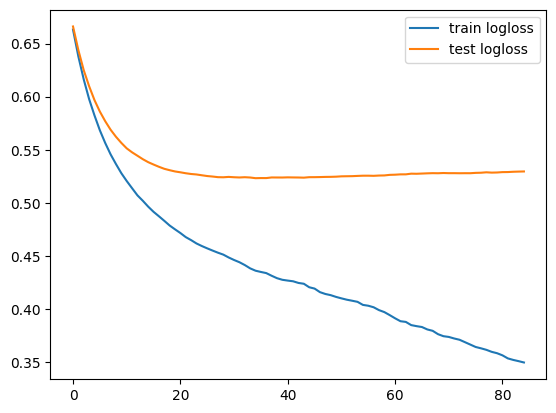

In [34]:

# plot logloss over time for train and test sets:
plt.plot(evals_result['train']['logloss'], label='train logloss')
plt.plot(evals_result['test']['logloss'], label='test logloss')


plt.legend()
plt.show()



In [35]:

best_iteration = model.best_iteration
print(best_iteration)





34


In [36]:
#Prep the submission format:
validation_df["pred"]= model.predict(xgb.DMatrix(test_df), ntree_limit=best_iteration)
validation_df["id"] = validation_df.index

#save to file:
validation_df[["id", "pred"]].to_csv("results/submission.csv", index=False)

/Users/m98612/venv/fradrag2021/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/var/folders/9_/syprsqwd263_tvl61_yf9pwm0000gn/T/ipykernel_63042/1632241534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df["pred"]= model.predict(xgb.DMatrix(test_df), ntree_limit=best_iteration)
/var/folders/9_/syprsqwd263_tvl61_yf9pwm0000gn/T/ipykernel_63042/1632241534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

# Test of Hyperopt

In [31]:

search_space = {
    "objective": "binary:logistic",  # objective
    "eta": hp.loguniform("learning_rate", -4, -1.2),  # learning rate
    "min_child_weight": hp.loguniform(
        "min_child_weight", -1, 3
    ),  # minimum sum of weights of all observations required in child.
    "max_depth": scope.int(hp.quniform("max_depth", 4, 20, 1)),
    "subsample": hp.loguniform(
        "subsample", -0.91, 0
    ),  # fraction of observations to be randomly samples for each tree.
    "colsample_bytree": hp.loguniform(
        "colsample_bytree", -0.91, 0
    ),  # fraction of columns to be randomly sampled for each tree.
    "colsample_bylevel": hp.loguniform(
        "colsample_bylevel", -0.91, 0
    ),  # subsample ratio of columns for each split, in each level.
    "lambda": hp.loguniform(
        "lambda", -4, 0
    ),  # L2 regularization term on weights (Ridge)
    "alpha": hp.loguniform(
        "alpha", -4, -1.2
    ),  # L1 regularization term on weight (Lasso)
    "gamma": hp.loguniform(
        "gamma", -6, 2.7
    ),  # minimum loss reduction required to make a split
    "seed": 41,
}


def objective(search_space):
    """
    Encapsulated objective-function such that hyperopt function can reach input-data in objective function
    """
    dtrain = xgb.DMatrix(X_train.copy(), label=y_train)
    dtest = xgb.DMatrix(X_test.copy(), label=y_test)

    watchlist = [(dtrain, 'train'), (dtest, 'test')]
    verbose_eval = 50
    with mlflow.start_run(nested=True):
        search_space["eval_metric"] = ["error", "auc", "logloss"]
        num_round = 1000
        evals_result = {}
        num_features = 80
        bst = xgb.train(
            search_space,
            dtrain,
            num_round,
            evals=watchlist,
            evals_result=evals_result,
            early_stopping_rounds=50,
            verbose_eval=verbose_eval,
        )
        print(f"Stopping after {len(evals_result['train']['error'])} rounds")


        min_logloss_error= np.min(evals_result["test"]["logloss"])
        mlflow.xgboost.log_model(bst, artifact_path="model")

        #use cross validation to get the best iteration:
        # cv_results = xgb.cv(
        #    search_space,
        #   dtrain,
        #   num_boost_round=num_round,
        #  nfold=5,
        # early_stopping_rounds=50,
        # verbose_eval=verbose_eval,
        # show_stdv=False,
        # )
        # print(cv_results)
        # min_logloss_error = cv_results["test-logloss-mean"].min()
        # print(f"Best logloss: {min_logloss_error}")
        # best_iteration = cv_results["test-logloss-mean"].idxmin()
        # print(f"Best iteration: {best_iteration}")
        # mlflow.log_metric("best_iteration", best_iteration)
        # mlflow.log_metric("best_logloss", min_logloss_error)
        #  

        return {
            "status": STATUS_OK,
            "loss": min_logloss_error,
            "booster": bst.attributes(),
        }



In [38]:
#
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.xgboost.autolog(
    log_input_examples=False, log_model_signatures=True, log_models=True
)


2022/11/04 12:15:33 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


In [32]:

mlflow.set_experiment("hyperopt_test_5_subset")

mlflow.xgboost.autolog(
    log_input_examples=False, log_model_signatures=True, log_models=True
)


with mlflow.start_run(run_name="test"):
    best_params = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=100,
    )


2022/11/04 20:54:50 INFO mlflow.tracking.fluent: Experiment with name 'hyperopt_test_5_subset' does not exist. Creating a new experiment.
2022/11/04 20:54:50 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


[0]	train-error:0.18094	train-auc:0.88703	train-logloss:0.62962	test-error:0.35100	test-auc:0.71579	test-logloss:0.66473
[50]	train-error:0.00106	train-auc:0.99996	train-logloss:0.12800	test-error:0.29150	test-auc:0.79569	test-logloss:0.56648
[70]	train-error:0.00019	train-auc:1.00000	train-logloss:0.08237	test-error:0.29325	test-auc:0.79541	test-logloss:0.58178
Stopping after 72 rounds                               
[0]	train-error:0.25731	train-auc:0.82848	train-logloss:0.67569	test-error:0.31250	test-auc:0.75825	test-logloss:0.67961
[50]	train-error:0.12156	train-auc:0.94935	train-logloss:0.38183	test-error:0.28500	test-auc:0.80381	test-logloss:0.53001
[100]	train-error:0.09300	train-auc:0.96871	train-logloss:0.33269	test-error:0.28375	test-auc:0.80430	test-logloss:0.52875
[128]	train-error:0.07575	train-auc:0.97763	train-logloss:0.31297	test-error:0.28350	test-auc:0.80399	test-logloss:0.53015
Stopping after 130 rounds                                                        
[0]	trai

# Make predictions:

In [39]:

#current best model:
# Load model as a PyFuncModel.
#path to local model:
logged_model2 = "mlruns/7/83515d1538024eaa852eb684ebaa1c02/artifacts/model"

#loaded_model1 = mlflow.xgboost.load_model(logged_model1)
loaded_model2 = mlflow.xgboost.load_model(logged_model2)
loaded_model3 = mlflow.pyfunc.load_model(logged_model2)
# find the best model from the run:
best_run = mlflow.search_runs(experiment_ids=mlflow.get_experiment_by_name("hyperopt_test_5_subset").experiment_id, order_by=["metrics.test_logloss ASC"]).iloc[1]

print(best_run)

# load the best model:
loaded_model4 = mlflow.xgboost.load_model(f"runs:/{best_run.run_id}/model")
loaded_model4 = mlflow.pyfunc.load_model(f"runs:/{best_run.run_id}/model")




run_id                                            1b2aa9c22f4347e08d61d26a59074707
experiment_id                                                                    8
status                                                                    FINISHED
artifact_uri                     ./mlruns/8/1b2aa9c22f4347e08d61d26a59074707/ar...
start_time                                        2022-11-04 20:32:16.880000+00:00
end_time                                          2022-11-04 20:32:36.246000+00:00
metrics.test-auc                                                          0.809102
metrics.train-error                                                         0.0215
metrics.test-error                                                           0.277
metrics.best_iteration                                                       129.0
metrics.test-logloss                                                      0.523911
metrics.train-auc                                                         0.996038
metr

In [106]:
print(loaded_model2)
print(loaded_model3)

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.xgboost
  run_id: cd1d6d5f985044c58327ff5a92d0510d



In [40]:
#Validate model on the validation_df_500 

validation_df_500 = validation_df[list_of_K_best_features]
#Prep the submission format:
validation_df_500["pred"]= loaded_model3.predict(validation_df_500)
validation_df_500["id"] = validation_df.index

#save to file:
validation_df_500[["id", "pred"]].to_csv("results/submission_hyperopt_best500_preprocess3.csv", index=False)



# 3.0 Try Tabnet


### 3.1 imports:

In [149]:

#Import libraries:
import numpy as np
import pandas as pd
import torch
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.callbacks import Callback

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer    
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score

#-----------------------------------------------
# callback object for MLflow integration
#-----------------------------------------------
class MLCallback(Callback):
    def on_train_begin(self, logs=None):
        
        mlflow.set_tracking_uri(MLF_TRACK_URI)
        mlflow.set_experiment(MLF_EXP_NAME)
        mlflow.start_run()
        mlflow.log_params(params)
        
    def on_train_end(self, logs=None):
        
        #log model:
        #save model to mlflow:
        #save model temporary local as pickle:
        
        with open("model.pkl", "wb") as f:
            pickle.dump(clf, f)

        #log the artifact to local folder:
        mlflow.log_artifact("model.pkl")


        #remove the local file:
        os.remove("model.pkl")
        

        #log model params:
        mlflow.end_run()
        
    def on_epoch_end(self, epoch, logs=None):
    
        # send to MLFlow
        mlflow.log_metric("train_auc", logs['train_auc'])
        mlflow.log_metric("test_auc", logs["test_auc"])
        # log logloss
        mlflow.log_metric("train_logloss", logs['train_logloss'])
        # log test logloss
        mlflow.log_metric("test_logloss", logs["test_logloss"])


### 3.2 Tabnet Preprocessing


In [191]:
# Preprocessing of the PCA dataframe:
#-----------------------------------------------
#drop label: 

# scale the data between 0 and 1:
scaler = MinMaxScaler()
traintest_df_PCA = scaler.fit_transform(traintest_df_PCA)


#use the scaler on validation_df_PCA:
validation_df_PCA = scaler.transform(validation_df_PCA)

#-----------------------------------------------

#add label to the PCA dataframe:



array([[0.22157633, 0.28326884, 0.36699717, ..., 0.4287035 , 0.4467494 ,
        0.51951046],
       [0.39118822, 0.25936471, 0.53240802, ..., 0.60263593, 0.66646506,
        0.51928646],
       [0.19429985, 0.36670328, 0.38280369, ..., 0.43693889, 0.51667208,
        0.43606572],
       ...,
       [0.07192755, 0.33848796, 0.47368865, ..., 0.466203  , 0.46950663,
        0.42194336],
       [0.28597205, 0.31722673, 0.50084435, ..., 0.46477771, 0.45796893,
        0.53304558],
       [0.01855163, 0.36866017, 0.47478804, ..., 0.44457589, 0.48429303,
        0.5243973 ]])

In [184]:
X, y  = traintest_df_PCA.drop("label", axis=1), traintest_df_PCA["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#-----------------------------------------------#print all shapes:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(16000, 800)
(4000, 800)
(16000,)
(4000,)


### 3.3 Tabnet Model: 

In [185]:
#Run tabnet:
#define constants:

mlflow.end_run()
MLF_TRACK_URI = "http://localhost:5000"
MLF_EXP_NAME = "tabnet_runs"
mlcbck = MLCallback()

#------------------EXPLANATION-----------------------------
#batch size means how many rows are used for each gradient update
#virtual batch size on the other hand is the number of rows used for each gradient update before the weights are updated
#num workers is the number of threads used for data loading
#weights is the weight of each class and should be used if the classes are unbalanced
#----------------------------------------------------------
clf = TabNetClassifier()
#eval set: ['auc', 'accuracy', 'balanced_accuracy', 'logloss', 'mae', 'mse', 'rmsle', 'unsup_loss', 'unsup_loss_numpy', 'rmse']
clf.fit(
    X_train=X_train.values, y_train=y_train.values,
    eval_set=[(X_train.values, y_train.values), (X_test.values, y_test.values)],
    eval_name=['train', 'test'],
    eval_metric=['auc','logloss'],
    max_epochs=1000, patience=50,
    batch_size=528, virtual_batch_size=64,
    num_workers=0,
    weights=1,
    callbacks=[mlcbck],
    drop_last=False
)


epoch 0  | loss: 0.70023 | train_auc: 0.6541  | train_logloss: 0.71857 | test_auc: 0.6582  | test_logloss: 0.72488 |  0:00:05s
epoch 1  | loss: 0.67619 | train_auc: 0.5717  | train_logloss: 0.71469 | test_auc: 0.56562 | test_logloss: 0.72067 |  0:00:10s
epoch 2  | loss: 0.67342 | train_auc: 0.57174 | train_logloss: 0.72079 | test_auc: 0.5754  | test_logloss: 0.72771 |  0:00:15s
epoch 3  | loss: 0.67178 | train_auc: 0.61435 | train_logloss: 0.73207 | test_auc: 0.6108  | test_logloss: 0.74158 |  0:00:20s
epoch 4  | loss: 0.66358 | train_auc: 0.6175  | train_logloss: 0.73487 | test_auc: 0.615   | test_logloss: 0.74684 |  0:00:24s
epoch 5  | loss: 0.66801 | train_auc: 0.62672 | train_logloss: 0.71838 | test_auc: 0.62954 | test_logloss: 0.72613 |  0:00:29s
epoch 6  | loss: 0.66488 | train_auc: 0.65482 | train_logloss: 0.73229 | test_auc: 0.65844 | test_logloss: 0.7418  |  0:00:33s


KeyboardInterrupt: 

In [157]:
#make prediction on validation set_clean:

"""
The default parameters for TabNet are:
    n_D = 8
    n_A = 8
    n_steps = 3
    gamma = 1.3
    n_independent = 2
    n_shared = 2
    epsilon = 1e-15
    momentum = 0.3
    lambda_sparse = 1e-3
    seed = 0
    clip_value = 2
    optimizer_fn = torch.optim.Adam
    optimizer_params = dict(lr=2e-2, weight_decay=1e-5)
    mask_type = "entmax" # "sparsemax"
    scheduler_params = dict(mode="min", patience=5, min_lr=1e-5, factor=0.9)
    scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau
    verbose = 10
    cat_idxs = []
    cat_dims = []
    cat_emb_dim = 1
    device_name = None
    
"""
mlflow.end_run()
mlcbck = MLCallback()
MLF_TRACK_URI = "http://localhost:5000"
MLF_EXP_NAME = "tabnet_runs"
#make params dict with distribution:
params = {
    'n_d': scope.int(hp.quniform('n_d', 16, 64, 1)),
    'n_a': scope.int(hp.quniform('n_a', 16, 64, 1)),
    'n_steps': scope.int(hp.quniform('n_steps', 3, 10, 1)),
    'gamma': hp.uniform('gamma', 1.0, 2.0),
    'n_independent': scope.int(hp.quniform('n_independent', 1, 5, 1)),
    'n_shared': scope.int(hp.quniform('n_shared', 1, 5, 1)),
    'lambda_sparse': hp.uniform('lambda_sparse', 1e-5, 1e-1),
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=hp.loguniform('lr', np.log(1e-5), np.log(1e-2))),
    'mask_type': hp.choice('mask_type', ['sparsemax', 'entmax'])
}

#make the objective function:
def objective(params):
    clf = TabNetClassifier(**params)
    clf.fit(
        X_train=X_train.values, y_train=y_train.values,
        eval_set=[(X_train.values, y_train.values), (X_test.values, y_test.values)],
        eval_name=['train', 'test'],
        eval_metric=['auc','logloss'],
        max_epochs=1000, patience=25,
        batch_size=528, virtual_batch_size=64,
        num_workers=0,
        weights=1,
        callbacks=[mlcbck],
        drop_last=False
    )
    y_pred = clf.predict_proba(X_test.values)
    #optimize on logloss:
    #return the best logloss form all epochs:
    return min(clf.history['test_logloss'])
    
#run the optimization:
best = fmin(
    fn=objective,
    space=params,
    algo=tpe.suggest,
    max_evals=100,
    trials=Trials(),
)


    

epoch 0  | loss: 2.63958 | train_auc: 0.26199 | train_logloss: 1.85492 | test_auc: 0.26135 | test_logloss: 1.81979 |  0:00:04s
epoch 1  | loss: 2.63943 | train_auc: 0.26246 | train_logloss: 1.64784 | test_auc: 0.2612  | test_logloss: 1.61769 |  0:00:08s
epoch 2  | loss: 2.62139 | train_auc: 0.2918  | train_logloss: 1.50202 | test_auc: 0.28578 | test_logloss: 1.47743 |  0:00:11s
epoch 3  | loss: 2.55981 | train_auc: 0.32408 | train_logloss: 1.45101 | test_auc: 0.31266 | test_logloss: 1.44091 |  0:00:13s
epoch 4  | loss: 2.57852 | train_auc: 0.35862 | train_logloss: 1.38771 | test_auc: 0.35603 | test_logloss: 1.36949 |  0:00:16s
epoch 5  | loss: 2.58327 | train_auc: 0.38609 | train_logloss: 1.34734 | test_auc: 0.38508 | test_logloss: 1.33214 |  0:00:19s
epoch 6  | loss: 2.57601 | train_auc: 0.40189 | train_logloss: 1.48223 | test_auc: 0.40282 | test_logloss: 1.46611 |  0:00:21s
epoch 7  | loss: 2.57149 | train_auc: 0.42288 | train_logloss: 1.47964 | test_auc: 0.41702 | test_logloss: 1.47

KeyboardInterrupt: 

In [178]:
#make new empty dataframe:

In [182]:
#
blend_df = pd.DataFrame()
#make a prediction on validation_set_f_classif, and add the prediction to the blend_df:
y_pred = clf.predict_proba(validation_df_chi2.values)
blend_df["tabnet_chi2"] = y_pred[:,1]

#load the blend_df:
loaded_blend_df = pd.read_csv("blend_df.csv")

#add blend_df to loaded_blend_df:
loaded_blend_df = pd.concat([loaded_blend_df, blend_df], axis=1)

#save to blend_df:
loaded_blend_df.to_csv("blend_df.csv", index=False)


,tabnet_f_classif,tabnet_chi2
0,0.625263,0.618708
1,0.735045,0.649769
2,0.245663,0.252469
3,0.368006,0.349584
4,0.159606,0.124988
...,...,...
19995,0.170167,0.202123
19996,0.306913,0.350665
19997,0.516423,0.498134
19998,0.450064,0.420638
